# Multi-label classification -- top-push loss

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.optimize import check_grad
from scipy.misc import logsumexp
from scipy.special import expit as sigmoid

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, make_scorer, label_ranking_loss

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

In [2]:
sys.path.append('src')
from evaluate import avgPrecisionK, evaluatePrecision, evaluateF1, evaluateRankingLoss, f1_score_nowarn, calcLoss
from datasets import create_dataset, dataset_names, nLabels_dict

In [3]:
dataset_names

['yeast', 'scene', 'bibtex', 'bookmarks', 'delicious', 'mediamill']

In [4]:
data_ix = 2

In [5]:
dataset_name = dataset_names[data_ix]
nLabels = nLabels_dict[dataset_name]
print(dataset_name, nLabels)

bibtex 159


In [6]:
data_dir = 'data'
SEED = 918273645
fmodel_base = os.path.join(data_dir, 'tp-' + dataset_name + '-base.pkl')
fmodel_prec = os.path.join(data_dir, 'tp-' + dataset_name + '-prec.pkl')
fmodel_noclsw = os.path.join(data_dir, 'tp-' + dataset_name + '-noclsw.pkl')
fperf_base = os.path.join(data_dir, 'perf-tp-base.pkl')
fperf_prec = os.path.join(data_dir, 'perf-tp-prec.pkl')
fperf_noclsw = os.path.join(data_dir, 'perf-tp-noclsw.pkl')

Load dataset.

In [7]:
X_train, Y_train = create_dataset(dataset_name, train_data=True, shuffle=True, random_state=SEED)
X_test,  Y_test  = create_dataset(dataset_name, train_data=False)

Feature normalisation.

In [8]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_test  -= X_train_mean
X_test  /= X_train_std

In [9]:
def print_dataset_info(X_train, Y_train, X_test, Y_test):
    N_train, D = X_train.shape
    K = Y_train.shape[1]
    N_test = X_test.shape[0]
    print('%-45s %s' % ('Number of training examples:', '{:,}'.format(N_train)))
    print('%-45s %s' % ('Number of test examples:', '{:,}'.format(N_test)))
    print('%-45s %s' % ('Number of features:', '{:,}'.format(D)))
    print('%-45s %s' % ('Number of labels:', '{:,}'.format(K)))
    avgK_train = np.mean(np.sum(Y_train, axis=1))
    avgK_test  = np.mean(np.sum(Y_test, axis=1))
    print('%-45s %.3f (%.2f%%)' % ('Average number of positive labels (train):', avgK_train, 100*avgK_train / K))
    print('%-45s %.3f (%.2f%%)' % ('Average number of positive labels (test):', avgK_test, 100*avgK_test / K))
    #print('%-45s %.4f%%' % ('Average label occurrence (train):', np.mean(np.sum(Y_train, axis=0)) / N_train))
    #print('%-45s %.4f%%' % ('Average label occurrence (test):', np.mean(np.sum(Y_test, axis=0)) / N_test))
    print('%-45s %.3f%%' % ('Sparsity (percent) (train):', 100 * np.sum(Y_train) / np.prod(Y_train.shape)))
    print('%-45s %.3f%%' % ('Sparsity (percent) (test):', 100 * np.sum(Y_test) / np.prod(Y_test.shape)))

In [10]:
print('%-45s %s' % ('Dataset:', dataset_name))
print_dataset_info(X_train, Y_train, X_test, Y_test)

Dataset:                                      bibtex
Number of training examples:                  4,880
Number of test examples:                      2,515
Number of features:                           1,836
Number of labels:                             159
Average number of positive labels (train):    2.380 (1.50%)
Average number of positive labels (test):     2.444 (1.54%)
Sparsity (percent) (train):                   1.497%
Sparsity (percent) (test):                    1.537%


## top-push loss

Multi-label learning with top push loss.

In [11]:
#n = 100000
#m = 8000
#randM = np.random.rand(n, m)

In [12]:
#%%timeit
#print(np.sum(randM))

In [13]:
#%%timeit
#print(np.dot(np.ones(n), np.dot(randM, np.ones(m))))  # more efficient than np.sum()

In [14]:
def obj_toppush(w, X, Y, C, r=1, weighting=True):
    """
        Objective with L2 regularisation and top push loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x K
            - C: regularisation constant, C = 1 / lambda
            - r: parameter for log-sum-exp approximation
            - weighting: if True, divide K+ in top-push loss
    """
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
    assert(r > 0)
    assert(C > 0)
    
    W = w.reshape(K, D)  # theta
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    
    # instead of using diagonal matrix to scale each row of a matrix with a different factor,
    # we use Mat * Vec[:, None] which is more memory efficient
    
    if weighting is True:
        KPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
    else:
        KPosAll = np.ones(N)
        
    A_diag = 1.0 / KPosAll
    AY = Y * A_diag[:, None]
    
    T1 = np.dot(X, W.T)  # N by K
    #m0 = np.max(T1)  # underflow in np.exp(r*T1 - m1)
    m0 = 0.5 * (np.max(T1) + np.min(T1))
    m1 = r * m0
    #print('----------------')
    #print(np.min(T1), np.max(T1), m0)
    #print(np.min(r*T1), np.max(r*T1), m1)
    #print(np.min(r * T1 - m1), np.max(r * T1 - m1))
    T2 = np.multiply(1 - Y, np.exp(r * T1 - m1))  # N by K
    B_tilde_diag = np.dot(T2, np.ones(K))
    #print(np.max(B_tilde_diag), np.min(B_tilde_diag))  # big numbers here, can cause overflow in T3
    
    #T3 = np.exp(-T1 + m0) * np.power(B_tilde_diag, 1.0 / r)[:, None]
    #T4 = np.multiply(AY, np.log1p(T3))
    T3 = (-T1 + m0) + (1.0 / r) * np.log(B_tilde_diag)[:, None]
    #print(np.min(T3), np.max(T3))
    m2 = 0.5 * (np.min(T3) + np.max(T3))
    #T4 = np.logaddexp(0, T3)
    T4 = np.logaddexp(-m2, T3-m2) + m2
    T5 = np.multiply(AY, T4)  
    
    J = np.dot(w, w) * 0.5 / C + np.dot(np.ones(N), np.dot(T5, np.ones(K))) / N
    
    #T5 = 1.0 / (1.0 + np.divide(1.0, T3))
    #T5 = np.divide(T3, 1 + T3)
    T6 = np.exp(T3 - T4)
    O_diag = np.dot(np.multiply(Y, T6), np.ones(K))
    T7 = A_diag * (1.0 / B_tilde_diag) * O_diag
    
    G1 = np.dot(np.multiply(AY, T6).T, -X)
    G2 = np.dot((T2 * T7[:, None]).T, X)
    
    G = W / C + (G1 + G2) / N
    
    return (J, G.ravel())

In [15]:
def obj_toppush_loop(w, X, Y, C, r=1, weighting=True):
    """
        Objective with L2 regularisation and top push loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x K
            - C: regularisation constant, C = 1 / lambda
            - r: parameter for log-sum-exp approximation
    """
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
    assert(r > 0)
    assert(C > 0)
    
    W = w.reshape(K, D)  # theta
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    if weighting is True:
        KPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
    else:
        KPosAll = np.ones(N)
    
    for n in range(N):
        for k in range(K):
            if Y[n, k] == 1:
                s1 = np.sum([np.exp(r * np.dot(W[j, :] - W[k, :], X[n, :])) for j in range(K) if Y[n, j] == 0])
                J += np.log1p(np.power(s1, 1.0 / r)) / KPosAll[n]
    J = np.dot(w, w) * 0.5 / C + J / N
    
    for k in range(K):
        for n in range(N):
            if Y[n, k] == 1:
                t1 = np.sum([np.exp(r * np.dot(W[j, :] - W[k, :], X[n, :])) for j in range(K) if Y[n, j] == 0])
                t2 = -1.0 / (1 + np.power(t1, -1.0 / r))
                G[k, :] = G[k, :] + X[n, :] * t2 / KPosAll[n]
            else:
                sk = 0.0
                for k1 in range(K):
                    if Y[n, k1] == 1:
                        t3 = np.sum([np.exp(r * np.dot(W[j,:] - W[k1, :], X[n, :])) \
                                     for j in range(K) if Y[n, j] == 0])
                        t4 = np.exp(r * np.dot(W[k, :] - W[k1, :], X[n, :]))
                        sk += t4 / (np.power(t3, 1.0 - 1.0 / r) + t3)
                G[k, :] = G[k, :] + X[n, :] * sk / KPosAll[n]
                        
    G = W / C + G / N
    
    return (J, G.ravel())

Check gradient

In [16]:
#aa = np.array([0,1,2, 0])
#print(aa)
#print([aa[i] for i in range(4) if aa[i] != 0])
#print([aa[i] if aa[i] != 0 for i in range(4)])  # ERROR: invalid syntax
#print([aa[i] if aa[i] != 0 else 10 for i in range(4)])

In [17]:
#X_train = X_train[:50, :]
#Y_train = Y_train[:50, :]
#C = 1
##w0 = np.random.rand(Y_train.shape[1] * X_train.shape[1]) - 0.5
#w0 = 0.001 * np.random.randn(Y_train.shape[1] * X_train.shape[1])

In [18]:
#check_grad(lambda w: obj_toppush(w, X_train, Y_train, C, r=2)[0], 
#           lambda w: obj_toppush(w, X_train, Y_train, C, r=2)[1], w0)

In [19]:
#check_grad(lambda w: obj_toppush_loop(w, X_train, Y_train, C, r=2)[0], 
#           lambda w: obj_toppush_loop(w, X_train, Y_train, C, r=2)[1], w0)

In [20]:
%%script false
eps = 1.49e-08
w = np.zeros_like(w0)
for i in range(len(w0)):
    wi1 = w0.copy()
    wi2 = w0.copy()
    wi1[i] = wi1[i] - eps
    wi2[i] = wi2[i] + eps
    J1, _ = obj_toppush_loop(wi1, X_train, Y_train, C)
    J2, _ = obj_toppush_loop(wi2, X_train, Y_train, C)
    w[i] = (J2 - J1) / (2 * eps)
    #print(w[i])
J, w1 = obj_toppush_loop(w0, X_train, Y_train, C)
diff = w1 - w
np.sqrt(np.dot(diff, diff))

In [21]:
%%script false
print('%15s %15s %15s %15s' % ('J_Diff', 'J_loop', 'J_vec', 'G_Diff'))
for e in range(-6, 10):
    C = 10**(e)
    #w0 = init_var(X_train, Y_train)
    J,  G  = obj_toppush_loop(w0, X_train, Y_train, C, r=2)
    J1, G1 = obj_toppush(w0, X_train, Y_train, C, r=2)
    Gdiff = G1 - G
    #print('%-15g %-15g %-15g' % (J1 - J, J, J1))
    print('%15g %15g %15g %15g' % (J1 - J, J, J1, np.dot(Gdiff, Gdiff)))

In [22]:
# ValueError: scoring must return a number, NOT an array
def search_TH0(Y_true, Y_pred):
    """
        For a given label, search the best threshold in 100 candidates that sampled uniformly at random
        from all N+1 possible thresholds 
    """
    #SEED = 987654321
    #np.random.seed(SEED)
    N, K = Y_true.shape
    THs = np.zeros(K)
    for k in range(K):
        # compute threshold as the mean of two successive scores
        y = sorted(Y_pred[:, k])
        y1 = np.zeros(N+1)
        y2 = np.zeros(N+1)
        y1[:N] = y
        y1[N] = y[-1] + 1
        y2[1:] = y
        y2[0] = y[0] - 1
        TH = 0.5 * (y1 + y2)
        np.random.shuffle(TH)
        bestTH = 0
        bestF1 = 0
        for th in TH[:100]:
            F1 = f1_score_nowarn(Y_true[:, k], Y_pred[:, k] >= th)
            if F1 > bestF1:
                bestF1 = F1
                bestTH = th
        THs[k] = bestTH
    return THs

In [23]:
def get_TH(Y_true, Y_pred):
    allPreds = sigmoid(Y_pred)
    ranges = np.arange(0.01, 1, 0.01)
    #F1 = [f1_score_nowarn(Y_true, allPreds >= th, average='samples') for th in ranges]
    F1 = Parallel(n_jobs=4)(delayed(f1_score_nowarn)(Y_true, allPreds >= th, average='samples') for th in ranges)
    bestix = np.argmax(F1)
    return ranges[bestix]

In [24]:
class MLC_toppush(BaseEstimator):
    """All methods are necessary for a scikit-learn estimator"""
    
    def __init__(self, C=1, r=1, weighting=True):
        """Initialisation"""
        
        assert C > 0
        assert r > 0
        assert type(weighting) == bool
        self.C = C
        self.r = r
        self.weighting = weighting
        self.trained = False
        
    def fit(self, X_train, Y_train):
        """Model fitting by optimising the objective"""
        opt_method = 'L-BFGS-B' #'BFGS' #'Newton-CG'
        options = {'disp': 1, 'maxiter': 10**5, 'maxfun': 10**5} # , 'iprint': 99}
        print('\nC: %g, r: %g' % (self.C, self.r))
            
        N, D = X_train.shape
        K = Y_train.shape[1]
        #w0 = np.random.rand(K * D) - 0.5  # initial guess in range [-1, 1]
        w0 = 0.001 * np.random.randn(K * D)
        opt = minimize(obj_toppush, w0, args=(X_train, Y_train, self.C, self.r, self.weighting), \
                       method=opt_method, jac=True, options=options)
        if opt.success is True:
            self.W = np.reshape(opt.x, (K, D))
            self.trained = True
        else:
            sys.stderr.write('Optimisation failed')
            print(opt.items())
            self.trained = False
            
            
    def decision_function(self, X_test):
        """Make predictions (score is real number)"""
        
        assert self.trained is True, "Can't make prediction before training"
        D = X_test.shape[1]
        return np.dot(X_test, self.W.T)
        
    
    def predict(self, X_test):
        return self.decision_function(X_test)
    #    """Make predictions (score is boolean)"""   
    #    preds = sigmoid(self.decision_function(X_test))
    #    #return (preds >= 0)
    #    assert self.TH is not None
    #    return preds >= self.TH        
        
    # inherit from BaseEstimator instead of re-implement
    #
    #def get_params(self, deep = True):
    #def set_params(self, **params):

In [25]:
def dump_results(predictor, X_train, Y_train, X_test, Y_test, fname):
    """
        Compute and save performance results
    """
    preds_train = predictor.decision_function(X_train)
    preds_test  = predictor.decision_function(X_test)
    
    print('Training set:')
    perf_dict_train = evaluatePrecision(Y_train, preds_train, verbose=1)
    print()
    print('Test set:')
    perf_dict_test = evaluatePrecision(Y_test, preds_test, verbose=1)
    
    print()
    print('Training set:')
    perf_dict_train.update(evaluateRankingLoss(Y_train, preds_train))
    print(label_ranking_loss(Y_train, preds_train))
    print()
    print('Test set:')
    perf_dict_test.update(evaluateRankingLoss(Y_test, preds_test))
    print(label_ranking_loss(Y_test, preds_test))
    
    # compute F1 score w.r.t. different thresholds
    #TH1 = predictor.cv_results_['mean_test_TH'][clf.best_index_]
    #TH2 = np.mean(Y_train, axis=0)
    #TH3 = np.mean(TH2)
    
    preds_train_bin = sigmoid(preds_train)
    preds_test_bin  = sigmoid(preds_test)
    
    #F1_train1 = f1_score_nowarn(Y_train, sigmoid(preds_train) >= TH1, average='samples')
    #F1_test1  = f1_score_nowarn(Y_test, sigmoid(preds_test) >= TH1, average='samples')
    #print('\nTrain: %.4f, %f' % (F1_train1, f1_score(Y_train, sigmoid(preds_train) >= TH1, average='samples')))
    #print('\nTest : %.4f, %f' % (F1_test1, f1_score(Y_test, sigmoid(preds_test) >= TH1, average='samples')))
    
    #F1_train2 = f1_score_nowarn(Y_train, (preds_train_bin - TH2) >= 0, average='samples')
    #F1_test2  = f1_score_nowarn(Y_test, (preds_test_bin - TH2) >= 0, average='samples')
    #print('\nTrain: %.4f, %f' % (F1_train2, f1_score(Y_train, (preds_train_bin - TH2) >= 0, average='samples')))
    #print('\nTest : %.4f, %f' % (F1_test2, f1_score(Y_test, (preds_test_bin - TH2) >= 0, average='samples')))
    
    #F1_train3 = f1_score_nowarn(Y_train, preds_train_bin >= TH3, average='samples')
    #F1_test3  = f1_score_nowarn(Y_test, preds_test_bin >= TH3, average='samples')
    #print('\nTrain: %.4f, %f' % (F1_train3, f1_score(Y_train, preds_train_bin >= TH3, average='samples')))
    #print('\nTest : %.4f, %f' % (F1_test3, f1_score(Y_test, preds_test_bin >= TH3, average='samples')))
    
    #perf_dict_train.update({'F1': [(F1_train1,), (F1_train2,), (F1_train3,)]})
    #perf_dict_test.update( {'F1': [(F1_test1,),  (F1_test2,),  (F1_test3,)]})
    #perf_dict_train.update({'F1': [(F1_train2,), (F1_train3,)]})
    #perf_dict_test.update( {'F1': [(F1_test2,),  (F1_test3,)]})
    
    perf_dict = {'Train': perf_dict_train, 'Test': perf_dict_test}
    if os.path.exists(fname):
        _dict = pkl.load(open(fname, 'rb'))
        if dataset_name not in _dict:
            _dict[dataset_name] = perf_dict
    else:
        _dict = {dataset_name: perf_dict}
    pkl.dump(_dict, open(fname, 'wb'))
    
    print()
    print(pkl.load(open(fname, 'rb')))

In [26]:
old_settings = np.seterr(all='ignore')  # seterr to known value
np.seterr(all='raise')
#np.seterr(all='ignore')
#np.seterr(**old_settings)  # restore settings

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'ignore', 'under': 'ignore'}

In [27]:
#%memit model.fit(X_train[:30], Y_train[:30])
#%mprun -f minimize model.fit(X_train[:100], Y_train[:100])
#%mprun -f _minimize_slsqp model.fit(X_train[:10], Y_train[:10])

Default model.

In [ ]:
if os.path.exists(fmodel_base):
    clf = pkl.load(open(fmodel_base, 'rb'))
else:
    clf = clf = MLC_toppush()
    clf.fit(X_train, Y_train)
    pkl.dump(clf, open(fmodel_base, 'wb'))

In [ ]:
dump_results(clf, X_train, Y_train, X_test, Y_test, fperf_base)

Cross validation w.r.t. average precision@K.

In [ ]:
#mm = MLC_toppush(C=300000, r=4)
#mm.fit(X_train, Y_train)

In [28]:
def avgTPLoss(allTruth, allPred):
    return np.mean(calcLoss(allTruth, allPred, 'TopPush', njobs=4))

In [32]:
#ranges = range(-6, 7)
ranges = range(-3, 4)
parameters = [{'C': sorted([10**(e) for e in ranges] + [3 * 10**(e) for e in ranges]),
               'r': [8]}]
#scorer = {'Prec': make_scorer(avgPrecisionK)}#, 'TH': make_scorer(get_TH)}
scorer = {'Prec': make_scorer(avgTPLoss)}

In [33]:
if not os.path.exists(fmodel_prec):
    clf = GridSearchCV(MLC_toppush(), parameters, scoring=scorer, cv=5, n_jobs=1, refit='Prec')
    clf.fit(X_train, Y_train)
    #pkl.dump(clf, open(fmodel_prec, 'wb'))
else:
    clf = pkl.load(open(fmodel_prec, 'rb'))


C: 0.001, r: 8

C: 0.001, r: 8

C: 0.001, r: 8

C: 0.001, r: 8

C: 0.001, r: 8

C: 0.003, r: 8

C: 0.003, r: 8

C: 0.003, r: 8

C: 0.003, r: 8

C: 0.003, r: 8

C: 0.01, r: 8

C: 0.01, r: 8

C: 0.01, r: 8

C: 0.01, r: 8

C: 0.01, r: 8

C: 0.03, r: 8

C: 0.03, r: 8

C: 0.03, r: 8

C: 0.03, r: 8

C: 0.03, r: 8

C: 0.1, r: 8

C: 0.1, r: 8

C: 0.1, r: 8

C: 0.1, r: 8

C: 0.1, r: 8

C: 0.3, r: 8

C: 0.3, r: 8

C: 0.3, r: 8

C: 0.3, r: 8

C: 0.3, r: 8

C: 1, r: 8

C: 1, r: 8

C: 1, r: 8

C: 1, r: 8

C: 1, r: 8

C: 3, r: 8

C: 3, r: 8

C: 3, r: 8

C: 3, r: 8

C: 3, r: 8

C: 10, r: 8

C: 10, r: 8

C: 10, r: 8

C: 10, r: 8

C: 10, r: 8

C: 30, r: 8

C: 30, r: 8

C: 30, r: 8

C: 30, r: 8

C: 30, r: 8

C: 100, r: 8

C: 100, r: 8

C: 100, r: 8

C: 100, r: 8

C: 100, r: 8

C: 300, r: 8

C: 300, r: 8

C: 300, r: 8

C: 300, r: 8

C: 300, r: 8

C: 1000, r: 8

C: 1000, r: 8

C: 1000, r: 8

C: 1000, r: 8

C: 1000, r: 8

C: 3000, r: 8

C: 3000, r: 8

C: 3000, r: 8

C: 3000, r: 8

C: 3000, r: 8

C: 0.001,

In [34]:
dump_results(clf, X_train, Y_train, X_test, Y_test, fperf_prec)

Training set:
Average Precision@3: 0.3827, 0.003
Average Precision@5: 0.2916, 0.002
Average Precision@10: 0.1862, 0.002
Average Precision@K: 0.5239, 0.006

Test set:
Average Precision@3: 0.2867, 0.005
Average Precision@5: 0.2216, 0.003
Average Precision@10: 0.1502, 0.002
Average Precision@K: 0.3804, 0.007

Training set:
Average RankingLoss: 15.2928, 0.499
0.0296222570546

Test set:
Average RankingLoss: 33.3666, 1.069
0.0797738220608

{'bibtex': {'Train': {'Precision@3': (0.62964480874316942, 0.004085705906020959), 'Precision@5': (0.43139344262295087, 0.0035121212714884715), 'Precision@K': (0.93740041123493978, 0.0025972356894115819), 'RankingLoss': (2.2200819672131149, 0.2085265910016372), 'F1': [(0.029299233417923957,), (0.029298835366993976,)]}, 'Test': {'Precision@3': (0.39257786613651424, 0.0056286626500821968), 'Precision@5': (0.2875546719681909, 0.0040758950776321129), 'Precision@K': (0.50769365547198553, 0.0077713693002391228), 'RankingLoss': (22.757057654075545, 0.8416758333229

Cross validation w.r.t. average precision@K, without weighting positive labels in objective.

In [ ]:
ranges = range(-6, 5)
parameters = [{'C': sorted([10**(e) for e in ranges] + [3 * 10**(e) for e in ranges]),
               'r': [0.5, 1, 2, 4]}]
if not os.path.exists(fmodel_noclsw):
    clf = GridSearchCV(MLC_toppush(weighting=False), parameters, scoring=scorer, cv=5, n_jobs=1, refit='Prec')
    clf.fit(X_train, Y_train)
    pkl.dump(clf, open(fmodel_noclsw, 'wb'))
else:
    clf = pkl.load(open(fmodel_noclsw, 'rb'))

In [ ]:
pak_train = []
pak_test = []
C_set = [0.01, 0.1, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 300, 1000, 3000]
for C in C_set:
    clf = MLC_toppush(C=C, r=8)
    clf.fit(X_train, Y_train)
    pak_train.append(avgPrecisionK(Y_train, clf.decision_function(X_train)))
    pak_test.append(avgPrecisionK(Y_test, clf.decision_function(X_test)))    

In [43]:
print('avg training loss:', np.mean(calcLoss(Y_train, clf.decision_function(X_train), metricType='TopPush')))
print('avg testing  loss:', np.mean(calcLoss(Y_test, clf.decision_function(X_test), metricType='TopPush')))

avg training loss: 0.554516320144
avg testing  loss: 0.688853496683


NameError: name 'C_set' is not defined

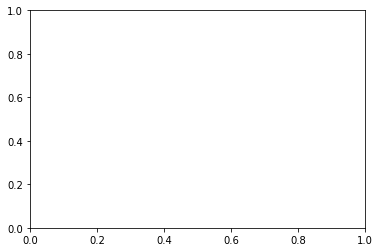

In [36]:
ax = plt.subplot('111')
#ax.plot(np.arange(len(C_set)), pak_train, ls='-', c='g', label='Train')
#ax.plot(np.arange(len(C_set)), pak_test, ls='-', c='r', label='Test')
ax.plot(C_set, pak_train, ls='-', c='g', label='Train')
ax.plot(C_set, pak_test, ls='-', c='r', label='Test')
ax.set_ylabel('Precision@K')
ax.set_xlabel('Regularisation constant C')
ax.set_xscale('log')
#ax.set_xticks(C_set)
#plt.xticks(np.arange(len(C_set)), C_set)
#plt.title('Learning curve of precision@k on bibtex dataset')
#plt.legend()

In [ ]:
from evaluate import calcLoss
from matplotlib.ticker import NullFormatter
plot_loss_of_clf(clf, X_train, Y_train, X_test, Y_test)

In [ ]:
def plot_loss_of_clf(clf, X_train, Y_train, X_test, Y_test):
    preds_train = clf.decision_function(X_train)
    tploss_train = calcLoss(Y_train, preds_train, 'TopPush', njobs=4)
    pak_train = calcLoss(Y_train, preds_train, 'Precision@K', njobs=4)
    preds_test = clf.decision_function(X_test)
    tploss_test = calcLoss(Y_test, preds_test, 'TopPush', njobs=4)
    pak_test = calcLoss(Y_test, preds_test, 'Precision@K', njobs=4)
    #plot_loss(tploss_train, pak_train, 'Training set (' + dataset_name + ')')
    
    plot_loss(tploss_test, pak_test, 'Test set (' + dataset_name + ')')

In [ ]:
def plot_loss(loss, pak, title):
    # the data
    x = loss
    y = 1 - pak
    
    print('away from diagonal portion:', np.mean(loss != 1-pak))

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y, color='b', alpha=0.5)
    axScatter.plot([0, 1], [0, 1], ls='--', color='g')
    axScatter.set_xlabel('Top push loss', fontdict={'fontsize': 12})
    axScatter.set_ylabel('1 - precision@K', fontdict={'fontsize': 12})

    # now determine nice limits by hand:
    #binwidth = 0.25
    #xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    #lim = (int(xymax/binwidth) + 1) * binwidth

    #axScatter.set_xlim((-lim, lim))
    #axScatter.set_ylim((-lim, lim))

    #bins = np.arange(-lim, lim + binwidth, binwidth)

    axHistx.hist(x, bins=10, color='g', alpha=0.3)
    axHistx.set_yscale('log')
    axHisty.hist(y, bins=10, color='g', alpha=0.3, orientation='horizontal')
    axHisty.set_xscale('log')

    #axHistx.set_xlim(axScatter.get_xlim())
    #axHisty.set_ylim(axScatter.get_ylim())

    axHistx.set_title(title, fontdict={'fontsize': 15}, loc='center')

Compute threshold for F1:
- approach I: grid search in range(0.01, 1) with step 0.01 during cross-validation.
- approach II: for each label, let the threshold be the average probability (to be +1) in training set.
- approach III: let the threshold be the average of all thresholds computed in approach II.

In [ ]:
%%script false

#TH1 = clf.cv_results_['mean_test_TH'][clf.best_index_]
#print(TH1)

TH2 = np.mean(Y_train, axis=0)
TH3 = np.mean(TH2)

#F1_train1 = f1_score_nowarn(Y_train, sigmoid(preds_train) >= TH1, average='samples')
#F1_test1  = f1_score_nowarn(Y_test, sigmoid(preds_test) >= TH1, average='samples')
#print('Train: %.4f \n' % F1_train1, f1_score(Y_train, sigmoid(preds_train) >= TH1, average='samples'))
#print('Test : %.4f \n' % F1_test1, f1_score(Y_test, sigmoid(preds_test) >= TH1, average='samples'))

F1_train2 = f1_score_nowarn(Y_train, (preds_train - TH2) >= 0, average='samples')
F1_test2  = f1_score_nowarn(Y_test, (preds_test - TH2) >= 0, average='samples')
print('Train: %.4f \n' % F1_train2, f1_score(Y_train, (preds_train - TH2) >= 0, average='samples'))
print('Test : %.4f \n' % F1_test2, f1_score(Y_test, (preds_test - TH2) >= 0, average='samples'))

F1_train3 = f1_score_nowarn(Y_train, preds_train >= TH3, average='samples')
F1_test3  = f1_score_nowarn(Y_test, preds_test >= TH3, average='samples')
print('Train: %.4f \n' % F1_train3, f1_score(Y_train, preds_train >= TH3, average='samples'))
print('Test : %.4f \n' % F1_test3, f1_score(Y_test, preds_test >= TH3, average='samples'))

## Result analysis

Plot the histogram of the $K$-th highest prediction scores, where $K$ is the number of positive labels for a given example.

In [ ]:
%%script false

K_train = Y_train.sum(axis=1).astype(np.int)
K_test = Y_test.sum(axis=1).astype(np.int)

K_pred_train = [sorted(preds_train[n, :])[::-1][K_train[n]-1] for n in range(X_train.shape[0])]
K_pred_test = [sorted(preds_test[n, :])[::-1][K_test[n]-1] for n in range(X_test.shape[0])]

fig = plt.figure(figsize=[10, 3])
plot_data = [K_pred_train, K_pred_test]
plt.suptitle('Histogram on %s dataset' % dataset_name)
for i in range(2):
    ax = plt.subplot(1,2,i+1)
    ax.hist(plot_data[i], bins=20)
    ax.set_title('%s set' % ('Training' if i == 0 else 'Test'))
    ax.set_xlabel('K-th highest prediction score')
    ax.set_ylabel('Frequency')
plt.savefig(dataset_name + '_kscore_hist.svg')

#print(K_pred_train[0], K_train[0])
#print(K_pred_test[0], K_test[0])

#preds_train[0, :]
#preds_test[0, :]

precisions_train = [avgPrecision(Y_train, preds_train, k) for k in range(1, nLabels+1)]
precisions_test  = [avgPrecision(Y_test,  preds_test,  k) for k in range(1, nLabels+1)]

precisionK_train = avgPrecisionK(Y_train, preds_train)
precisionK_test  = avgPrecisionK(Y_test,  preds_test)

plt.figure(figsize=[10,5])
plt.plot(precisions_train, ls='--', c='r', label='Train')
plt.plot(precisions_test,  ls='-',  c='g', label='Test')
plt.plot([precisionK_train for k in range(nLabels)], ls='-', c='r', label='Train, Precision@K')
plt.plot([precisionK_test  for k in range(nLabels)], ls='-', c='g', label='Test, Precision@K')
plt.xticks(np.arange(nLabels), np.arange(1,nLabels+1))
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.legend(loc='best')
plt.title('MLC w. Top-push Loss on ' + dataset_name + ' dataset')
#plt.savefig(dataset_name + '_tp.svg')